In [2]:
import numpy as np
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import load_model, Model

from attention import Attention


def main():
   
    num_samples, time_steps, input_dim, output_dim = 100, 10, 1, 1
    data_x = np.random.uniform(size=(num_samples, time_steps, input_dim))
    data_y = np.random.uniform(size=(num_samples, output_dim))

    # Define/compile the model.
    model_input = Input(shape=(time_steps, input_dim))
    x = LSTM(64, return_sequences=True)(model_input)
    x = Attention(32)(x)
    x = Dense(1)(x)
    model = Model(model_input, x)
    model.compile(loss='mae', optimizer='adam')
    print(model.summary())

    # train.
    model.fit(data_x, data_y, epochs=10)

    # test save/reload model.
    pred1 = model.predict(data_x)
    model.save('test_model.h5')
    model_h5 = load_model('test_model.h5')
    pred2 = model_h5.predict(data_x)
    np.testing.assert_almost_equal(pred1, pred2)
    print('Success.')


if __name__ == '__main__':
    main()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 10, 64)       16896       input_1[0][0]                    
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 64)           0           lstm[0][0]                       
__________________________________________________________________________________________________
attention_score_vec (Dense)     (None, 10, 64)       4096        lstm[0][0]                       
______________________________________________________________________________________________

In [16]:
import torch
import torch.nn as nn
import numpy as np

In [17]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

x = np.array([2.0, 1.0, 0.1])
outputs = softmax(x)
print('softmax numpy:', outputs)

x = torch.tensor([2.0, 1.0, 0.1])
outputs = torch.softmax(x, dim=0) # along values along first axis
print('softmax torch:', outputs)

softmax numpy: [0.65900114 0.24243297 0.09856589]
softmax torch: tensor([0.6590, 0.2424, 0.0986])


In [18]:
def cross_entropy(actual, predicted):
    EPS = 1e-15
    predicted = np.clip(predicted, EPS, 1 - EPS)
    loss = -np.sum(actual * np.log(predicted))
    return loss # / float(predicted.shape[0])
Y = np.array([1, 0, 0])
Y_pred_good = np.array([0.7, 0.2, 0.1])
Y_pred_bad = np.array([0.1, 0.3, 0.6])
l1 = cross_entropy(Y, Y_pred_good)
l2 = cross_entropy(Y, Y_pred_bad)
print(f'Loss1 numpy: {l1:.4f}')
print(f'Loss2 numpy: {l2:.4f}')
loss = nn.CrossEntropyLoss()
Y = torch.tensor([0])
Y_pred_good = torch.tensor([[2.0, 1.0, 0.1]])
Y_pred_bad = torch.tensor([[0.5, 2.0, 0.3]])
l1 = loss(Y_pred_good, Y)
l2 = loss(Y_pred_bad, Y)
print(f'PyTorch Loss1: {l1.item():.4f}')
print(f'PyTorch Loss2: {l2.item():.4f}')

# get predictions
_, predictions1 = torch.max(Y_pred_good, 1)
_, predictions2 = torch.max(Y_pred_bad, 1)
print(f'Actual class: {Y.item()}, Y_pred1: {predictions1.item()}, Y_pred2: {predictions2.item()}')

Loss1 numpy: 0.3567
Loss2 numpy: 2.3026
PyTorch Loss1: 0.4170
PyTorch Loss2: 1.8406
Actual class: 0, Y_pred1: 0, Y_pred2: 1


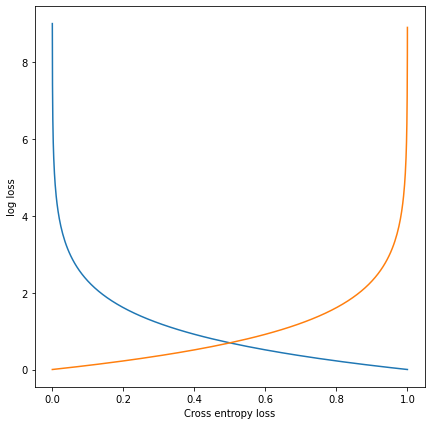

In [1]:
import numpy as np
import matplotlib.pyplot as plt
def sig(x):
    return 1.0/(1.0+np.exp(-x))
def softmax_cross_entropy(z,y):
    if y==1:
        return -np.log(z)
    else:
        return -np.log(1-z)
x=np.arange(-9,9,0.1)
a=sig(x)
softmax1=softmax_cross_entropy(a,1)
softmax2=softmax_cross_entropy(a,0)
figure,axis=plt.subplots(figsize=(7,7))
plt.plot(a,softmax1)
plt.plot(a,softmax2)
plt.xlabel("Cross entropy loss")
plt.ylabel("log loss")
plt.show()

In [2]:
pip install transformer

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement transformer (from versions: none)
ERROR: No matching distribution found for transformer
You should consider upgrading via the 'E:\Users\HP\anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
from fastai.text import *

ModuleNotFoundError: No module named 'fastai'

<ipython-input-8-ba966098b350>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(attn_scores).view(1, 1, -1)


Epoch: 0400 cost = 0.000493
Epoch: 0800 cost = 0.000162
Epoch: 1200 cost = 0.000081
Epoch: 1600 cost = 0.000048
Epoch: 2000 cost = 0.000032
je veux du thé P -> ['i', 'want', 'a', 'tea', 'now']


<ipython-input-8-ba966098b350>:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
<ipython-input-8-ba966098b350>:120: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})


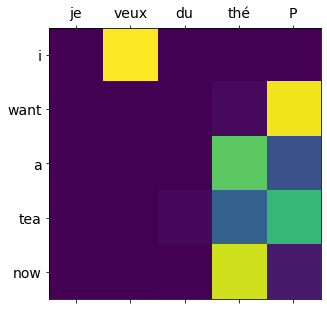

In [8]:
# %%

# Reference : https://github.com/hunkim/PyTorchZeroToAll/blob/master/14_2_seq2seq_att.py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps

def make_batch():
    input_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[0].split()]]]
    output_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[1].split()]]]
    target_batch = [[word_dict[n] for n in sentences[2].split()]]

    # make tensor
    return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)

class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
        self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)

        # Linear for attention
        self.attn = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden * 2, n_class)

    def forward(self, enc_inputs, hidden, dec_inputs):
        enc_inputs = enc_inputs.transpose(0, 1)  # enc_inputs: [n_step(=n_step, time step), batch_size, n_class]
        dec_inputs = dec_inputs.transpose(0, 1)  # dec_inputs: [n_step(=n_step, time step), batch_size, n_class]

        # enc_outputs : [n_step, batch_size, num_directions(=1) * n_hidden], matrix F
        # enc_hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        enc_outputs, enc_hidden = self.enc_cell(enc_inputs, hidden)

        trained_attn = []
        hidden = enc_hidden
        n_step = len(dec_inputs)
        model = torch.empty([n_step, 1, n_class])

        for i in range(n_step):  # each time step
            # dec_output : [n_step(=1), batch_size(=1), num_directions(=1) * n_hidden]
            # hidden : [num_layers(=1) * num_directions(=1), batch_size(=1), n_hidden]
            dec_output, hidden = self.dec_cell(dec_inputs[i].unsqueeze(0), hidden)
            attn_weights = self.get_att_weight(dec_output, enc_outputs)  # attn_weights : [1, 1, n_step]
            trained_attn.append(attn_weights.squeeze().data.numpy())

            # matrix-matrix product of matrices [1,1,n_step] x [1,n_step,n_hidden] = [1,1,n_hidden]
            context = attn_weights.bmm(enc_outputs.transpose(0, 1))
            dec_output = dec_output.squeeze(0)  # dec_output : [batch_size(=1), num_directions(=1) * n_hidden]
            context = context.squeeze(1)  # [1, num_directions(=1) * n_hidden]
            model[i] = self.out(torch.cat((dec_output, context), 1))

        # make model shape [n_step, n_class]
        return model.transpose(0, 1).squeeze(0), trained_attn

    def get_att_weight(self, dec_output, enc_outputs):  # get attention weight one 'dec_output' with 'enc_outputs'
        n_step = len(enc_outputs)
        attn_scores = torch.zeros(n_step)  # attn_scores : [n_step]

        for i in range(n_step):
            attn_scores[i] = self.get_att_score(dec_output, enc_outputs[i])

        # Normalize scores to weights in range 0 to 1
        return F.softmax(attn_scores).view(1, 1, -1)

    def get_att_score(self, dec_output, enc_output):  # enc_outputs [batch_size, num_directions(=1) * n_hidden]
        score = self.attn(enc_output)  # score : [batch_size, n_hidden]
        return torch.dot(dec_output.view(-1), score.view(-1))  # inner product make scalar value

if __name__ == '__main__':
    n_step = 5 # number of cells(= number of Step)
    n_hidden = 128 # number of hidden units in one cell

    sentences = ['je veux du thé P', 'S i want a tea', 'i want a tea now']

    word_list = " ".join(sentences).split()
    word_list = list(set(word_list))
    word_dict = {w: i for i, w in enumerate(word_list)}
    number_dict = {i: w for i, w in enumerate(word_list)}
    n_class = len(word_dict)  # vocab list

    # hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
    hidden = torch.zeros(1, 1, n_hidden)

    model = Attention()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    input_batch, output_batch, target_batch = make_batch()

    # Train
    for epoch in range(2000):
        optimizer.zero_grad()
        output, _ = model(input_batch, hidden, output_batch)

        loss = criterion(output, target_batch.squeeze(0))
        if (epoch + 1) % 400 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

        loss.backward()
        optimizer.step()

    # Test
    test_batch = [np.eye(n_class)[[word_dict[n] for n in 'SPPPP']]]
    test_batch = torch.FloatTensor(test_batch)
    predict, trained_attn = model(input_batch, hidden, test_batch)
    predict = predict.data.max(1, keepdim=True)[1]
    print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

    # Show Attention
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(trained_attn, cmap='viridis')
    ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
    ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})
    plt.show()

In [1]:
from fastai.text import *

ModuleNotFoundError: No module named 'fastai'

In [1]:
''' This module will handle the text generation with beam search. '''

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformer.Models import Transformer, get_pad_mask, get_subsequent_mask


class Translator(nn.Module):
    ''' Load a trained model and translate in beam search fashion. '''

    def __init__(
            self, model, beam_size, max_seq_len,
            src_pad_idx, trg_pad_idx, trg_bos_idx, trg_eos_idx):
        

        super(Translator, self).__init__()

        self.alpha = 0.7
        self.beam_size = beam_size
        self.max_seq_len = max_seq_len
        self.src_pad_idx = src_pad_idx
        self.trg_bos_idx = trg_bos_idx
        self.trg_eos_idx = trg_eos_idx

        self.model = model
        self.model.eval()

        self.register_buffer('init_seq', torch.LongTensor([[trg_bos_idx]]))
        self.register_buffer(
            'blank_seqs', 
            torch.full((beam_size, max_seq_len), trg_pad_idx, dtype=torch.long))
        self.blank_seqs[:, 0] = self.trg_bos_idx
        self.register_buffer(
            'len_map', 
            torch.arange(1, max_seq_len + 1, dtype=torch.long).unsqueeze(0))


    def _model_decode(self, trg_seq, enc_output, src_mask):
        trg_mask = get_subsequent_mask(trg_seq)
        dec_output, *_ = self.model.decoder(trg_seq, trg_mask, enc_output, src_mask)
        return F.softmax(self.model.trg_word_prj(dec_output), dim=-1)


    def _get_init_state(self, src_seq, src_mask):
        beam_size = self.beam_size

        enc_output, *_ = self.model.encoder(src_seq, src_mask)
        dec_output = self._model_decode(self.init_seq, enc_output, src_mask)
        
        best_k_probs, best_k_idx = dec_output[:, -1, :].topk(beam_size)

        scores = torch.log(best_k_probs).view(beam_size)
        gen_seq = self.blank_seqs.clone().detach()
        gen_seq[:, 1] = best_k_idx[0]
        enc_output = enc_output.repeat(beam_size, 1, 1)
        return enc_output, gen_seq, scores


    def _get_the_best_score_and_idx(self, gen_seq, dec_output, scores, step):
        assert len(scores.size()) == 1
        
        beam_size = self.beam_size

        # Get k candidates for each beam, k^2 candidates in total.
        best_k2_probs, best_k2_idx = dec_output[:, -1, :].topk(beam_size)

        # Include the previous scores.
        scores = torch.log(best_k2_probs).view(beam_size, -1) + scores.view(beam_size, 1)

        # Get the best k candidates from k^2 candidates.
        scores, best_k_idx_in_k2 = scores.view(-1).topk(beam_size)
 
        # Get the corresponding positions of the best k candidiates.
        best_k_r_idxs, best_k_c_idxs = best_k_idx_in_k2 // beam_size, best_k_idx_in_k2 % beam_size
        best_k_idx = best_k2_idx[best_k_r_idxs, best_k_c_idxs]

        # Copy the corresponding previous tokens.
        gen_seq[:, :step] = gen_seq[best_k_r_idxs, :step]
        # Set the best tokens in this beam search step
        gen_seq[:, step] = best_k_idx

        return gen_seq, scores


    def translate_sentence(self, src_seq):
        # Only accept batch size equals to 1 in this function.
        # TODO: expand to batch operation.
        assert src_seq.size(0) == 1

        src_pad_idx, trg_eos_idx = self.src_pad_idx, self.trg_eos_idx 
        max_seq_len, beam_size, alpha = self.max_seq_len, self.beam_size, self.alpha 

        with torch.no_grad():
            src_mask = get_pad_mask(src_seq, src_pad_idx)
            enc_output, gen_seq, scores = self._get_init_state(src_seq, src_mask)

            ans_idx = 0   # default
            for step in range(2, max_seq_len):    # decode up to max length
                dec_output = self._model_decode(gen_seq[:, :step], enc_output, src_mask)
                gen_seq, scores = self._get_the_best_score_and_idx(gen_seq, dec_output, scores, step)

                # Check if all path finished
                # -- locate the eos in the generated sequences
                eos_locs = gen_seq == trg_eos_idx   
                # -- replace the eos with its position for the length penalty use
                seq_lens, _ = self.len_map.masked_fill(~eos_locs, max_seq_len).min(1)
                # -- check if all beams contain eos
                if (eos_locs.sum(1) > 0).sum(0).item() == beam_size:
                    # TODO: Try different terminate conditions.
                    _, ans_idx = scores.div(seq_lens.float() ** alpha).max(0)
                    ans_idx = ans_idx.item()
                    break
        return gen_seq[ans_idx][:seq_lens[ans_idx]].tolist()

ModuleNotFoundError: No module named 'transformer'

In [3]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'E:\Users\HP\anaconda3\python.exe -m pip install --upgrade pip' command.


In [4]:
python -m pip install transformers

SyntaxError: invalid syntax (<ipython-input-4-5c61c0b9f0f1>, line 1)

In [5]:
    !which pip

'which' n’est pas reconnu en tant que commande interne
ou externe, un programme exécutable ou un fichier de commandes.


In [1]:
from bertviz import head_view
from transformers import BertTokenizer, BertModel

ModuleNotFoundError: No module named 'bertviz'

In [2]:
pip install bertviz

Note: you may need to restart the kernel to use updated packages.


In [1]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased", output_attentions=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
inputs = tokenizer.encode("bert is a good language model", return_tensors='pt')
outputs = model(inputs)
attention = outputs[-1]  # Output includes attention weights when output_attentions=True
tokens = tokenizer.convert_ids_to_tokens(inputs[0]) 

In [3]:
from bertviz import head_view
head_view(attention, tokens)

<IPython.core.display.Javascript object>

In [4]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-de")
model = AutoModel.from_pretrained("Helsinki-NLP/opus-mt-en-de", output_attentions=True)

Some weights of the model checkpoint at Helsinki-NLP/opus-mt-en-de were not used when initializing MarianModel: ['final_logits_bias']
- This IS expected if you are initializing MarianModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MarianModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
encoder_input_ids = tokenizer("She sees the small elephant.", return_tensors="pt", add_special_tokens=True).input_ids
decoder_input_ids = tokenizer("Sie sieht den kleinen Elefanten.", return_tensors="pt", add_special_tokens=True).input_ids

outputs = model(input_ids=encoder_input_ids, decoder_input_ids=decoder_input_ids)

encoder_text = tokenizer.convert_ids_to_tokens(encoder_input_ids[0])
decoder_text = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

In [6]:
from bertviz import model_view
model_view(
    encoder_attention=outputs.encoder_attentions,
    decoder_attention=outputs.decoder_attentions,
    cross_attention=outputs.cross_attentions,
    encoder_tokens= encoder_text,
    decoder_tokens = decoder_text
)

<IPython.core.display.Javascript object>

In [9]:
%tb

SystemExit: True

In [7]:
from bertviz import head_view
from transformers import BertTokenizer, BertModel

In [8]:
def show_head_view(model, tokenizer, sentence_a, sentence_b=None, layer=None, heads=None):
    inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
    input_ids = inputs['input_ids']
    if sentence_b:
        token_type_ids = inputs['token_type_ids']
        attention = model(input_ids, token_type_ids=token_type_ids)[-1]
        sentence_b_start = token_type_ids[0].tolist().index(1)
    else:
        attention = model(input_ids)[-1]
        sentence_b_start = None
    input_id_list = input_ids[0].tolist() # Batch index 0
    tokens = tokenizer.convert_ids_to_tokens(input_id_list)    
    head_view(attention, tokens, sentence_b_start, layer=layer, heads=heads)

In [9]:
model_version = 'bert-base-uncased'
do_lower_case = True
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)
sentence_a = "the tea is delicious"
sentence_b = "The coffee is good"
show_head_view(model, tokenizer, sentence_a, sentence_b)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<IPython.core.display.Javascript object>

In [10]:
from bertviz import head_view
import torch
from transformers import BertTokenizer, TFBertForPreTraining
import tensorflow as tf

In [11]:
def show_head_view_tf(model, tokenizer, sentence_a, sentence_b=None):
    inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='tf', add_special_tokens=True)
    input_ids = inputs['input_ids']
    if sentence_b:
        token_type_ids = inputs['token_type_ids']
        attention = model(input_ids, token_type_ids=token_type_ids)[-1]
        sentence_b_start = token_type_ids[0].numpy().tolist().index(1)
    else:
        attention = model(input_ids)[-1]
        sentence_b_start = None
    
    # Convert attention from TF tensors to torch tensors
    attention = [torch.from_numpy(layer_attn.numpy()) for layer_attn in attention]
    
    input_id_list = input_ids[0].numpy().tolist() # Batch index 0
    tokens = tokenizer.convert_ids_to_tokens(input_id_list)    
    head_view(attention, tokens, sentence_b_start)

In [12]:
sentence_a = "bert language model is finally working"
sentence_b = "bert is a working language model"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForPreTraining.from_pretrained('bert-base-uncased', output_attentions=True)
show_head_view_tf(model, tokenizer, sentence_a, sentence_b)

All model checkpoint layers were used when initializing TFBertForPreTraining.

All the layers of TFBertForPreTraining were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForPreTraining for predictions without further training.


<IPython.core.display.Javascript object>

In [13]:
from bertviz import head_view
from transformers import GPT2Tokenizer, GPT2Model

In [14]:
model_version = 'gpt2'
model = GPT2Model.from_pretrained(model_version, output_attentions=True)
tokenizer = GPT2Tokenizer.from_pretrained(model_version)
text = "The quick brown fox jumps over the lazy dogs."
inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
attention = model(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
head_view(attention, tokens)

<IPython.core.display.Javascript object>